In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
#######
import statistics as stat
import scipy as sp
from bisect import bisect  # to compute time index
import pygsp
from pygsp import graphs
from pygsp import filters
#######
from matrixprofile.matrixProfile import stomp
from matrixprofile.motifs import motifs
from matrixprofile.discords import discords

In [2]:
signal = pd.read_csv('traffic_sum_node.csv', index_col=0) # read matrix of signals
G1 = nx.read_gml('/home/manuelherrera/Data/BT_data/graph_anonymous.gml')

G2 = G1.to_undirected()
#for c in nx.connected_components(G2):
#    G2.subgraph(c)
    
largest_cc = max(nx.connected_components(G2), key=len)

Gc = G2.subgraph(largest_cc) 
pos = nx.spring_layout(Gc) # layout by default that it is saved for future use

nnodes = len(Gc) # 222 nodes - 206 now
nedges = Gc.number_of_edges() # 730 edges - 722 now

node_names = list(Gc.nodes); link_names = list(Gc.edges)

# initializing substring 
subs = 'core-aln1'
node_names1 = [i for i in node_names if subs in i]

G = Gc.subgraph(node_names1)

pos = nx.spring_layout(G) # layout by default that it is saved for future use

# Fixing node classifications
G.nodes['core-aln1.tan-chachalaca']['nodeType'] = 'regional'
G.nodes['core-aln1.whimsical-angelfish']['nodeType'] = 'metro'

nodes_super = [x for x,y in G.nodes(data=True) if y['nodeType']=='super']
nodes_regional = [x for x,y in G.nodes(data=True) if y['nodeType']=='regional']
nodes_metro = [x for x,y in G.nodes(data=True) if y['nodeType']=='metro']
nodes_inner = [x for x,y in G.nodes(data=True) if y['nodeType']=='super' or y['nodeType']=='regional']
nodes_outer = [x for x,y in G.nodes(data=True) if y['nodeType']=='regional' or y['nodeType']=='metro']
df_inner = signal[nodes_inner]
df_outer = signal[nodes_outer]

In [3]:
Network2 = G.subgraph(nodes_inner)
remove = [node for node,degree in dict(Network2.degree()).items() if degree == 0]
Network = Network2.copy()
Network.remove_nodes_from(remove)
#df_inner

In [4]:
# Also remove those nodes from the BT_inner dataframe !! IMPORTANT -- done cell above ??
remove_list = []
for node in remove:
    if node in df_inner.columns:
        df_inner.drop(node, axis=1, inplace=True)
        
print("Number of columns:"); print(len(df_inner.columns)); print("Number of network nodes:"); print(len(Network))

Number of columns:
13
Number of network nodes:
13


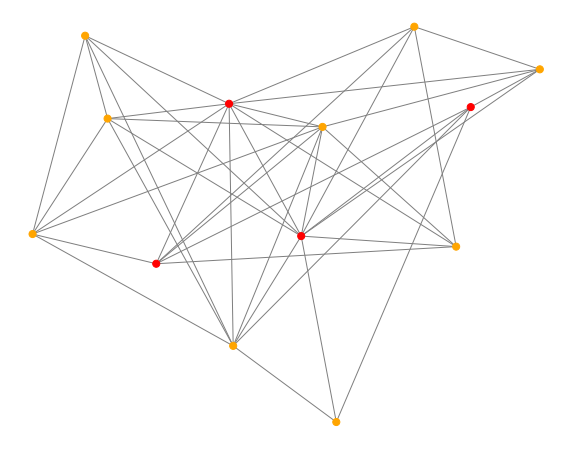

In [5]:
def color_map(Graph):
    color_map_n = []
    for i in Graph.nodes():
        if Graph.nodes[i]['nodeType'] == 'super':
            color_map_n.append('red')
        elif Graph.nodes[i]['nodeType'] == 'regional':
            color_map_n.append('orange')
        elif Graph.nodes[i]['nodeType'] == 'metro':
            color_map_n.append('green')
        else: color_map_n.append('blue')
    return color_map_n

color_map_n = color_map(Network)
f_inner = plt.figure(figsize=(10, 8))
plt.axis('off')
nx.draw_networkx(Network, pos, node_size=50, node_color = color_map_n, edge_color = "gray", with_labels=False)
plt.show()

In [18]:
cuenta = 0
for i in Network.nodes():
    print(cuenta, i, Network.nodes[i]['nodeType'])
    cuenta = cuenta + 1

0 core-aln1.celadon-aardwolf super
1 core-aln1.pistachio-cheetah regional
2 core-aln1a.diamond-gopher super
3 core-aln1.stalwart-grouse regional
4 core-aln1.tan-chachalaca regional
5 core-aln1.malachite-pheasant super
6 core-aln1.diamond-gopher super
7 core-aln1.sensible-cuttlefish regional
8 core-aln1.congenial-python regional
9 core-aln1.swinging-alpaca regional
10 core-aln1.curvy-gopher regional
11 core-aln1.marigold-curassow regional
12 core-aln1.slim-centipede regional


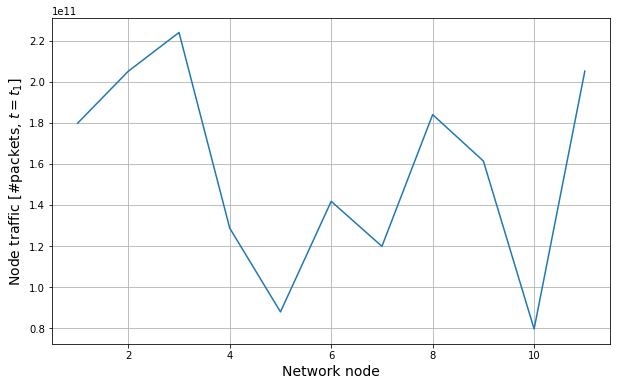

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Network node',  fontsize=14)
plt.ylabel('Node traffic [#packets, $t = t_1$]',  fontsize=14)
aux = [i for i in range(1, 12)]
ax.plot(aux, list(df_inner.loc[0][0:11])) #, color = 'grey', markersize=10)
#fig.savefig("Traffic_inner_t1.pdf", bbox_inches='tight')

In [9]:
peso = df_inner.loc[0] # t0 for testing purposes... This should vary from 0 up to T = 719 in this specific case
for i in Network.nodes():
    Network.nodes[i]['weight'] = peso[i]

A = nx.adjacency_matrix(Network, weight='weight')
Network1 = graphs.Graph(W = A, gtype = 'Inner core')
#Network1.set_coordinates('spring')
#Network1.plot(vertex_size=50)
#plt.axis('off'); plt.title('')
eig_val, U = sp.linalg.eigh(Network1.L.toarray()) 

In [10]:
T = 720
myInt = 10e9
eig_val = []; U = []; Networks = []
for t in range(T):
    peso = df_inner.loc[t]
    zpeso = [x / myInt for x in peso]
    for i in Network.nodes():
        Network.nodes[i]['weight'] = peso[i]
    A = nx.adjacency_matrix(Network, weight='weight')
    Network1 = graphs.Graph(W = A, gtype = 'Inner core')
    eig_val_aux, U_aux = sp.linalg.eigh(Network1.L.toarray())
    eig_val.append(eig_val_aux) # where eig_val[t] is the array of eig_val at time t
    U.append(U_aux) # where U[t] is the array of eigenvec at time t
    Networks.append(Network1)

In [11]:
eig_val[0][1:10] # Working with the first K eigenvectors corresponding to the lowest eigenvalues

array([2.47448593, 3.13737982, 4.48896243, 5.13161957, 5.89275759,
       5.99031969, 6.70132516, 7.70911765, 8.48403547])

In [12]:
tau = 1; nlambdas = 10;
spectra = []
for t in range(T):
    peso = df_inner.loc[t]
    zpeso = [x / myInt for x in peso]
    x0 = np.array(zpeso)
    Networks[t].compute_fourier_basis()
    g = filters.Heat(Networks[t], tau)
    x = g.filter(x0).squeeze()
    x_hat = Networks[t].gft(x).squeeze()
    spectra.extend(np.abs(x_hat).tolist()[1:nlambdas])  # Taking the TOP 10 eigenvectors; out the 1st because it is == 1 ...

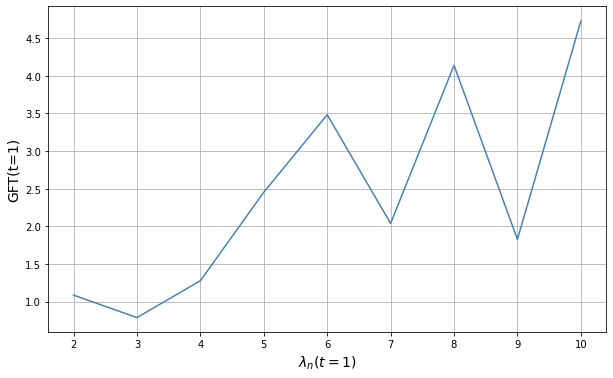

In [13]:
fg, ax = plt.subplots(figsize=(10, 6))
plt.grid(True)
plt.xlabel('$\lambda_n(t=1)$',  fontsize=14)
plt.ylabel('GFT(t=1)',  fontsize=14)
ax.plot([i for i in range(2, nlambdas + 1)], spectra[1:nlambdas], color = 'steelblue', markersize=4)
#fig.savefig("GSP_MP_inner_signal_example.pdf", bbox_inches='tight')

In [14]:
window_size = nlambdas # could take other length
mp, mpi = stomp(spectra, window_size)

In [ ]:
#fig, ax = plt.subplots(figsize=(18, 3))
#plt.grid(True)
#plt.xlabel('$\lambda_k(t)$ (N nodes) x t (T time units)',  fontsize=14)
#plt.ylabel('Matrix Profile',  fontsize=14)
#ax.plot(mp, color = 'steelblue', markersize=4)
#fig.savefig("GSP_MP_outer1b.pdf", bbox_inches='tight')

In [15]:
top_discords = discords(mp, window_size, k=5)

data = np.array(spectra, dtype=np.float32)
original_motifs = motifs(data, (mp,mpi), max_motifs=5, ex_zone=window_size, n_neighbors=5)
top_motifs = [item[0] for item in original_motifs[0]]

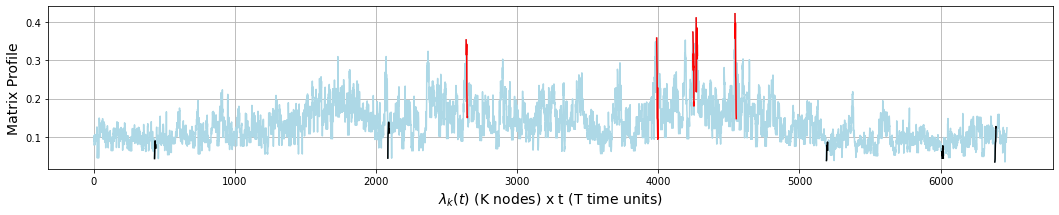

In [17]:
fig, ax = plt.subplots(figsize=(18, 3)) # top_motifs and top_discords
plt.grid(True)
plt.xlabel('$\lambda_k(t)$ (K nodes) x t (T time units)',  fontsize=14)
plt.ylabel('Matrix Profile',  fontsize=14)
ax.plot(mp, color = 'lightblue', markersize=4)
for start_index in top_motifs:
    aux = [i for i in range(start_index, start_index+window_size)]
    ax.plot(aux, mp[start_index:(start_index+window_size)], color = 'black')
for start_index in top_discords:
    aux = [i for i in range(start_index, start_index+window_size)]
    ax.plot(aux, mp[start_index:(start_index+window_size)], color = 'red')
fig.savefig("GSP_MP_inner1br.pdf", bbox_inches='tight')

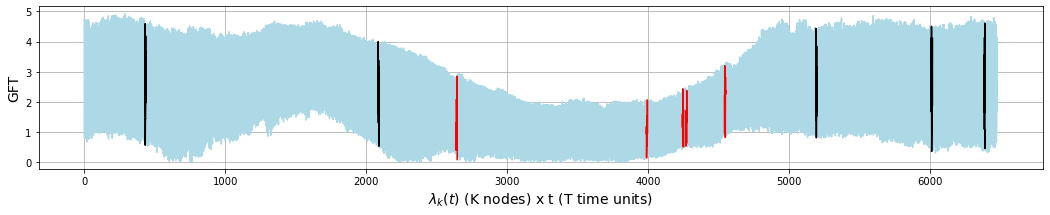

In [18]:
fig, ax = plt.subplots(figsize=(18, 3))
plt.grid(True)
plt.xlabel('$\lambda_k(t)$ (K nodes) x t (T time units)',  fontsize=14)
plt.ylabel('GFT',  fontsize=14)
ax.plot(spectra, color = 'lightblue', markersize=10)
for start_index in top_motifs:
    aux = [i for i in range(start_index, start_index+window_size)]
    ax.plot(aux, spectra[start_index:(start_index+window_size)], color = 'black')
for start_index in top_discords:
    aux = [i for i in range(start_index, start_index+window_size)]
    ax.plot(aux, spectra[start_index:(start_index+window_size)], color = 'red')
fig.savefig("GSP_MP_inner1ar.pdf", bbox_inches='tight')

In [19]:
nlambdas = 10 # defined above. To delete in the next session (today 23-10-20)
ind_left = [] # len(Network spectrum) = nlambdas; time from 0 up to 719 -- or is it 1 to 720 ? df_inner.shape[0] = 720
for i in range(0,df_inner.shape[0]):
    if i > 0:
        ind_left.append((nlambdas - 1)*i + 1)
    else: ind_left.append(0)

ind_right = []
for i in range(1,df_inner.shape[0]+1):
    ind_right.append((nlambdas - 1)*i)

In [20]:
top_discords

array([4543, 4268, 4244, 3988, 2638])

In [21]:
# time to event
discords_t = []; motifs_t = []
for i in top_discords:
    discords_t.append(bisect(ind_left, i))
samp_discords = discords_t # number of network with a discord
discords_t = [h*2 for h in discords_t] # minutes from 14:00

for j in top_motifs:
    motifs_t.append(bisect(ind_left, j))
samp_motifs = motifs_t  # number of network with a motif
motifs_t = [h*2 for h in motifs_t] # minutes from 14:00

In [22]:
for i in discords_t:
    hours = i // 60
    minutes = i % 60
    print("14:00 plus ""%d:%02d" % (hours, minutes))

14:00 plus 16:50
14:00 plus 15:50
14:00 plus 15:44
14:00 plus 14:48
14:00 plus 9:48


In [23]:
for i in motifs_t:
    hours = i // 60
    minutes = i % 60
    print("14:00 plus ""%d:%02d" % (hours, minutes))

14:00 plus 23:40
14:00 plus 19:14
14:00 plus 1:36
14:00 plus 22:16
14:00 plus 7:44


In [ ]:
# TO-DO next is to check one by one which nodes are involved in the discord / motif. That's is,
# check which eigenvalues intervend in such a distance
# go to the U matrix of the time samp_* 
# take the eigenvector corresponding to the eigenvalue
# see the combination of nodes in such an eigenvector

In [24]:
samp_discords

[505, 475, 472, 444, 294]

In [25]:
samp_motifs

[710, 577, 48, 668, 232]

In [26]:
# For each time, the network spectrum is defined by 2:11 top eigenvectors => size = 9
np_array = np.array(spectra)
reshaped_array = np.reshape(np_array, (720, 9))
a_dataframe = pd.DataFrame(reshaped_array)
a_dataframe

,0,1,2,3,4,5,6,7,8
0,4.729423,1.084920,0.786506,1.276039,2.452687,3.482245,2.038108,4.140456,1.825280
1,4.727315,1.091978,0.776701,1.333183,2.395917,3.484559,2.010266,4.131816,1.743023
2,4.696122,1.073689,0.674887,1.260156,2.270421,3.517287,2.002465,4.103373,1.726852
3,4.728946,1.054302,0.753482,1.316984,2.379018,3.634258,2.023951,4.083507,1.766175
4,4.655145,1.090306,0.777829,1.331396,2.396455,3.638941,2.061826,4.080225,1.753739
...,...,...,...,...,...,...,...,...,...
715,4.651276,0.607542,0.762631,1.168257,2.522595,3.617608,1.863700,4.218854,1.692278
716,4.607480,0.534592,0.790481,1.090799,2.515650,3.643069,1.858161,4.269260,1.699508
717,4.800282,0.478209,0.735634,1.169313,2.647441,3.634217,1.895771,4.225287,1.678182
718,4.663370,0.493337,0.801763,1.134685,2.550939,3.608962,1.954265,4.190283,1.698887


In [27]:
df_gft = a_dataframe.copy()
for i in top_discords:
    df_gft.drop(bisect(ind_left, i) - 1, axis=0, inplace=True)

mean_gsignal = df_gft.mean(axis = 0)

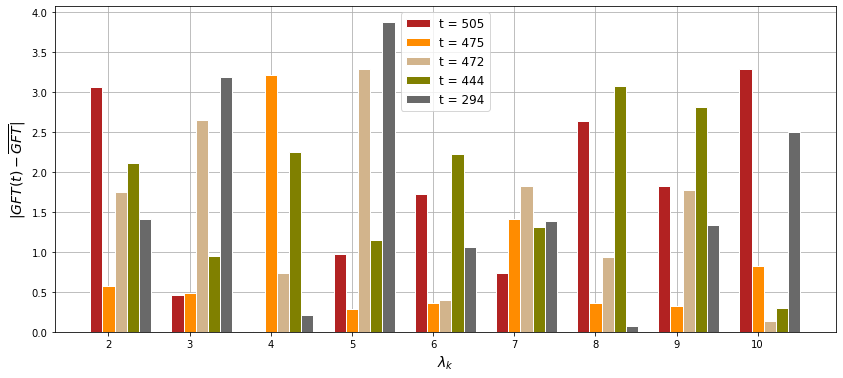

In [29]:
barWidth = 0.15
 
# set height of bar
bars = []
for i in samp_discords:
    aux = [abs(x - y) for x,y in zip(list(mean_gsignal),list(spectra[i:(i + 9)]))]
    bars.append(aux)

bars1 = bars[0]; bars2 = bars[1]; bars3 = bars[2]
bars4 = bars[3]; bars5 = bars[4]
    
# Set position of bar on X-axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]; r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]; r5 = [x + barWidth for x in r4]
 
# Make the plot
fg, ax = plt.subplots(figsize=(14, 6))
xaxis = [i for i in range(2, 11)]
plt.grid(True)
ax.set_axisbelow(True)

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(bars1))], [i for i in range(2, 11)])

plt.xlabel('$\lambda_k$',  fontsize=14) # [505, 475, 472, 444, 294]
plt.ylabel('$| GFT(t) - \overline{GFT} |$',  fontsize=14)
plt.bar(r1, bars1, color='firebrick', width=barWidth, edgecolor='white', label='t = 505')
plt.bar(r2, bars2, color='darkorange', width=barWidth, edgecolor='white', label='t = 475')
plt.bar(r3, bars3, color='tan', width=barWidth, edgecolor='white', label='t = 472')
plt.bar(r4, bars4, color='olive', width=barWidth, edgecolor='white', label='t = 444')
plt.bar(r5, bars5, color='dimgrey', width=barWidth, edgecolor='white', label='t = 294')
 
# Create legend & show graphic
plt.legend(fontsize=12)
plt.show()
fg.savefig("Inner_discords_dev.pdf", bbox_inches='tight')

In [30]:
discords_find1 = []
for i in samp_discords:
    aux = [abs(x - y) for x,y in zip(list(mean_gsignal),list(spectra[i:(i + 9)]))]
    discords_find1.append(aux)

discords_find1[0]

[3.055156173179041,
 0.4687107954697811,
 0.015271939664261547,
 0.9779250747162411,
 1.7276681423776254,
 0.740861983900873,
 2.6324124061193843,
 1.8274211487643859,
 3.287181535014171]

In [ ]:
#def condition(x): return x > stat.mean(discords_find1[0]) + 1.645*stat.stdev(discords_find1[0])
#output = [idx for idx, element in enumerate(discords_find1[0]) if condition(element)]
#output # which is the eigenvector/s to check out? this is the index column of U[bars[0]] ?

In [31]:
# Function to find out which eigenvector is of influence
def influence_point(x, vector): return x > stat.mean(vector) + 1.645*stat.stdev(vector)
V = U # to preserve U of any undesirable change

In [32]:
# checking the function... And it's OK.
output = [idx for idx, element in enumerate(discords_find1[0]) if influence_point(element,discords_find1[0])]
output

[]

In [33]:
len(discords_find1)

5

In [34]:
node_set = []
if len(discords_find1) > 0:
    for discord in discords_find1:
        eigencols = [idx for idx, element in enumerate(discord) if influence_point(element,discord)]
        if len(eigencols) > 0:
            for j in range(len(eigencols)):
                M = V[samp_discords[j]]
                for i in eigencols:
                    candidates = list(M[:, i])
                    node_aux = [idx for idx, element in enumerate(candidates) if influence_point(element,candidates)]
                    node_set.append(node_aux)

In [35]:
node_set

[[0], [6], [6]]

In [ ]:
# ---------------------- Similar analysis for motifs  --------------------------------------

In [36]:
motifs_find1 = []
for i in samp_motifs:
    aux = [abs(x - y) for x,y in zip(list(mean_gsignal),list(spectra[i:(i + 9)]))]
    motifs_find1.append(aux)

motifs_find1[0]

[2.190927591734618,
 3.2155212049980886,
 1.2041269455572745,
 0.879715306479945,
 0.5703051947847428,
 0.7284750928558013,
 2.0897140263268894,
 1.3522130773946834,
 2.7070979532413135]

In [37]:
len(motifs_find1)

5

In [38]:
node_set_m = []
if len(motifs_find1) > 0:
    for motif in motifs_find1:
        eigencols = [idx for idx, element in enumerate(motif) if influence_point(element,discord)]
        if len(eigencols) > 0:
            for j in range(len(eigencols)):
                M = V[samp_motifs[j]]
                for i in eigencols:
                    candidates = list(M[:, i])
                    node_aux = [idx for idx, element in enumerate(candidates) if influence_point(element,candidates)]
                    node_set_m.append(node_aux)

In [39]:
node_set_m

[]